<a href="https://colab.research.google.com/github/cekbote/ivp-assignments/blob/master/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNET Implementation

UNET is a Deep Convolutional Network that was invented for competing in the [ISBI challenge](http://2020.biomedicalimaging.org/challenges) for segmentation of neuronal structures in electron microscopic stacks. The network is novel due to its skip conections as well as its wighted loss function. The weighted loss function is required as there is a class imbalance between the black and white pixels. Due to this the binary cross entropy loss has to be wighted in such a way that the class imbalance does not prevent the model from learning. The network can be visualized below:

<p>&nbsp;</p>

<p align="center">
  <img src="https://miro.medium.com/max/3000/1*J3t2b65ufsl1x6caf6GiBA.png" width="700"/>
</p>


## Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Unet

/content/drive/MyDrive/Unet


In [ ]:
pwd

'/content/drive/MyDrive/Unet'

## Importing the Neccessary Libraries

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import backend as K
import seaborn as sns
from IPython.display import HTML, display
import tabulate

## Functions Used for the Project



In [ ]:
def create_dataset(path):
  """
    Function that is used to obtain the Dataset.

    Args:
        path: Contains the path of the dataset.

    Returns:
        X: Dataset containing the images.

  """

  images = []
  paths =  os.listdir(path)
  paths.sort()
  for i in paths:
      img = io.imread(path + i)
      images.append(img)
      X = np.array(images).astype(np.float32)
  return X

In [ ]:
def weighted_binary_crossentropy(weights):

  """
  A weighted version of keras.objectives.binary_crossentropy
  
    Args:
        weights: Contains the differnt weighting scheme of the loss.

    Returns:
        loss: Retunrns the total loss.
  """
  
  weights = K.variable(weights)
      
  def loss(y_true, y_pred):
      # scale predictions so that the class probas of each sample sum to 1
      y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
      # clip to prevent NaN's and Inf's
      y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
      # calc
      loss = weights[0]*y_true * K.log(y_pred) + weights[1]*(1-y_true) * K.log(1-y_pred)
      loss = -K.sum(loss, -1)
      return loss
  
  return loss

In [ ]:
def create_model():

  """
    Function that is used to create the Deep Learning model

    Args:
        path: Contains the path of the dataset.

    Returns:
        model: Returns a class that defines the UNET Model.

  """

  # Input Layer
  inputs = Input((512,512,1))

  # Conv Layer 1
  Conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  Conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv1)
  Pool1 = MaxPooling2D(pool_size=(2, 2))(Conv1)

  # Conv Layer 2
  Conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Pool1)
  Conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv2)
  Pool2 = MaxPooling2D(pool_size=(2, 2))(Conv2)

  # Conv Layer 3
  Conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Pool2)
  Conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv3)
  Pool3 = MaxPooling2D(pool_size=(2, 2))(Conv3)

  # Conv Layer 4
  Conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Pool3)
  Conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv4)
  drop4 = Dropout(0.5)(Conv4)
  Pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  # Conv Layer 5
  Conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Pool4)
  Conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv5)
  drop5 = Dropout(0.5)(Conv5)

  # Conv Layer 6
  Up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  Merge6 = concatenate([drop4,Up6], axis = 3)
  Conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Merge6)
  Conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv6)

  # Conv Layer 7
  Up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Conv6))
  Merge7 = concatenate([Conv3,Up7], axis = 3)
  Conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Merge7)
  Conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv7)

  # Conv Layer 8
  Up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Conv7))
  Merge8 = concatenate([Conv2,Up8], axis = 3)
  Conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Merge8)
  Conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv8)

  # Conv Layer 9
  Up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Conv8))
  Merge9 = concatenate([Conv1,Up9], axis = 3)
  Conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Merge9)
  Conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv9)
  Conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv9)

  # Conv Layer 10
  Conv10 = Conv2D(1, 1, activation = 'sigmoid')(Conv9)

  # Defining the Model
  model = Model(inputs= inputs, outputs= Conv10, name="UNET")

  # Defining the Weighted Loss
  loss = weighted_binary_crossentropy(np.array([4.0, 1.0]).astype(np.float32))

  # Compiling the Model
  model.compile(optimizer = Adam(lr = 1e-4), loss = loss, metrics = ['accuracy'])

  return model

## Defining the Model and Observing the Summary

In [ ]:
model = create_model()
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________________

## Processing the Dataset

In [ ]:
# Creating the Dataset from the File paths
X = create_dataset('/content/drive/My Drive/Unet/data/membrane/train/image/')/255
Y = create_dataset('/content/drive/My Drive/Unet/data/membrane/train/label/')
Y = (Y>125)*1.0

# Splitting the Dataset into Train and Test Datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 3)

# Shuffling the Dataset
X_train, Y_train = shuffle(X_train, Y_train, random_state = 2)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 0)

## Training the Model

In [ ]:
history = model.fit(X_train, Y_train, epochs = 50, batch_size = 5, validation_data = (X_test, Y_test), verbose = 1)

Epoch 1/50
5/5 [==============================] - 13s 3s/step - loss: 9905.6523 - accuracy: 0.7734 - val_loss: 10106.1338 - val_accuracy: 0.7909
Epoch 2/50
5/5 [==============================] - 7s 1s/step - loss: 9913.3047 - accuracy: 0.7758 - val_loss: 10103.9375 - val_accuracy: 0.7908
Epoch 3/50
5/5 [==============================] - 7s 1s/step - loss: 9912.3193 - accuracy: 0.6097 - val_loss: 10104.0254 - val_accuracy: 0.2205
Epoch 4/50
5/5 [==============================] - 7s 1s/step - loss: 9912.1670 - accuracy: 0.2302 - val_loss: 10104.0166 - val_accuracy: 0.2201
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 9912.1084 - accuracy: 0.2304 - val_loss: 10103.8857 - val_accuracy: 0.2186
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 9912.0068 - accuracy: 0.2313 - val_loss: 10103.7363 - val_accuracy: 0.2255
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 9911.7275 - accuracy: 0.2345 - val_loss: 10103.0645 - val_accuracy

## Displaying the Results

### PLotting the Loss and Accuracy Curves vs Number of Epochs

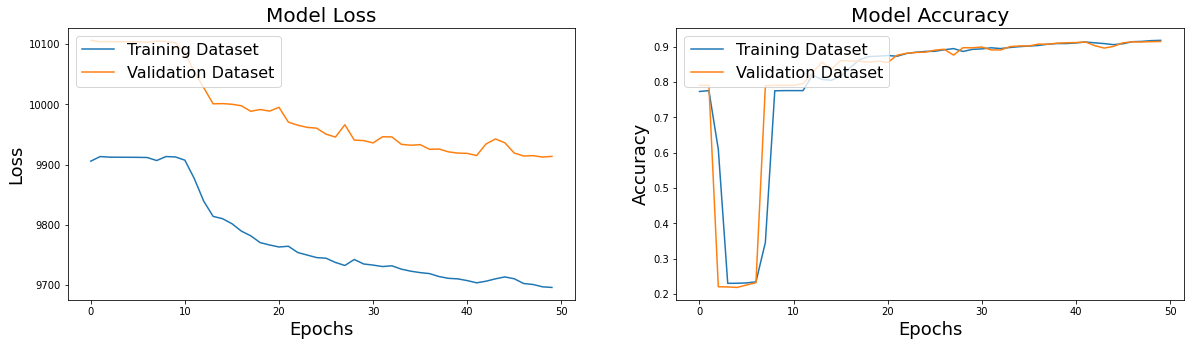

In [ ]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize= 20)
plt.ylabel('Loss', fontsize= 18)
plt.xlabel('Epochs', fontsize= 18)
plt.legend(['Training Dataset','Validation Dataset'], loc='upper left', fontsize = 16)

plt.subplot(1, 2, 2)
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy',fontsize= 20)
plt.ylabel('Accuracy', fontsize= 18)
plt.xlabel('Epochs', fontsize= 18)
plt.legend(['Training Dataset','Validation Dataset'], loc='upper left', fontsize = 16)

plt.show()

### Loss and Accuracy on the Train and Test Set

In [ ]:
loss_train, acc_train = model.evaluate(X_train, Y_train, batch_size=5)
loss_test, acc_test = model.evaluate(X_test,  Y_test, batch_size=5)

table = table = [["Dataset","Loss","Accuracy (%)"],
         ["Training Dataset",loss_train,acc_train * 100],
         ["Test DataSet",loss_test,acc_test * 100]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

2/2 [==============================] - 0s 194ms/step - loss: 9913.5830 - accuracy: 0.9150


### Output Images Obtained from the Trained Model on Test Images

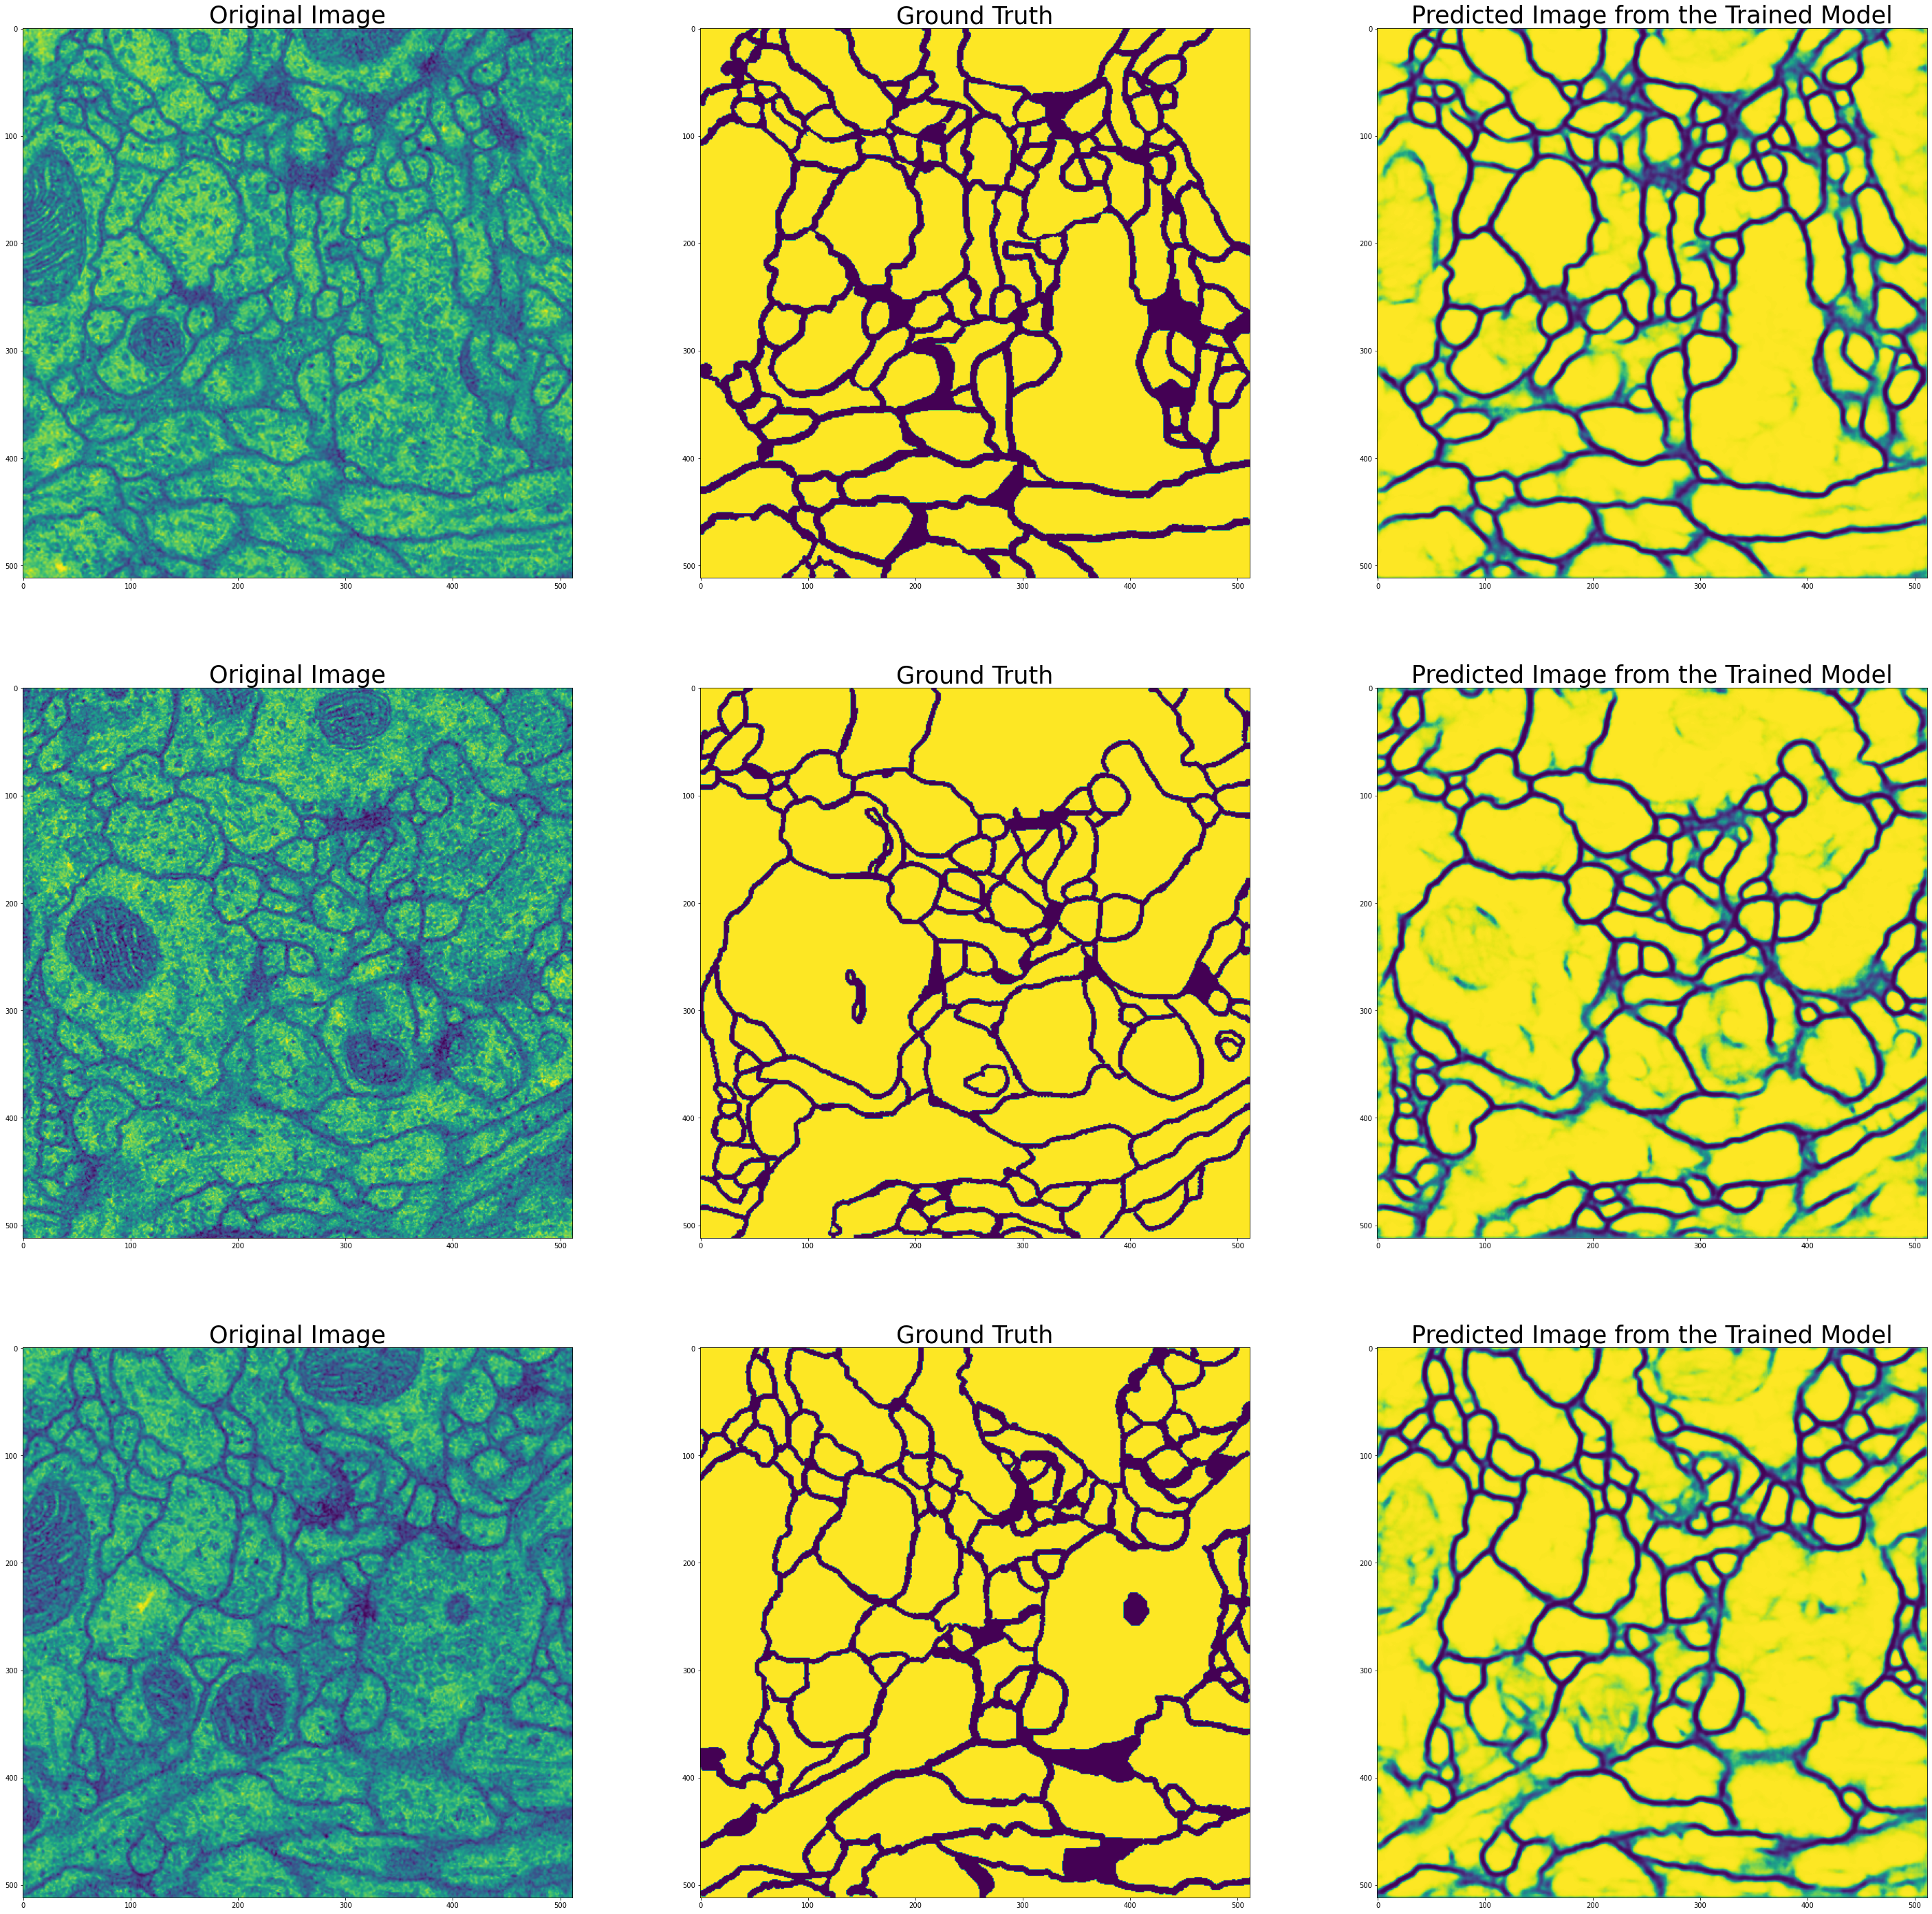

In [ ]:
predicted_images = model.predict(X_test[0:5,:,:])

for i in range(3):

  plt.rcParams["figure.figsize"] = (50,50)
  plt.subplot(3, 3, i*3 + 1)
  plt.title('Original Image', fontsize = 35)
  plt.imshow(X_test[i,:,:])

  plt.subplot(3, 3, i*3 + 2)
  plt.title('Ground Truth', fontsize = 35)
  plt.imshow(Y_test[i,:,:])

  plt.subplot(3, 3, i*3 + 3)
  plt.title('Predicted Image from the Trained Model', fontsize = 35)
  plt.imshow(predicted_images[i][:,:,0])

plt.show()

## Conclusion

Through this project we were able to generate images through which a human could differentiate between different regions of the cell. We also learnt the utility of the architecture of the UNET and also learn the importance of weighting imbalanced classes appropriately. Finally we were able to conclude that we could use a similar technique for satelite images to determine roads, rivers etc, which would be really usefull.